In [1]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

In [2]:
path = os.getcwd() + '\\augmented_data\\'

img_size = (64, 64)
trainX = np.zeros((72_800, img_size[0], img_size[1]))

In [3]:
update_per = 10000

for n, i in enumerate(os.listdir(path)):
    filename = os.fsdecode(i)
    temp_img = cv2.imread(path + filename, 0) / 255
    temp_img = cv2.resize(temp_img, img_size)
    trainX[n] = temp_img
    if n % update_per == 0:
        print(f'Image #: {n}')

Image #: 0
Image #: 10000
Image #: 20000
Image #: 30000
Image #: 40000
Image #: 50000
Image #: 60000
Image #: 70000


In [4]:
trainY = np.zeros(len(trainX))

In [5]:
# generator

random_input = tf.keras.layers.Input(shape = 100)

x = tf.keras.layers.Dense(img_size[0] * 5 * 5)(random_input)
x = tf.keras.layers.Activation('swish')(x)
x = tf.keras.layers.BatchNormalization(momentum=0.8)(x)

x = tf.keras.layers.Reshape((5, 5, img_size[0]))(x)

x = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=(5,5))(x)
x = tf.keras.layers.Activation('swish')(x)
x = tf.keras.layers.BatchNormalization(momentum=0.8)(x)

x = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=(7,7))(x)
x = tf.keras.layers.Activation('swish')(x)
x = tf.keras.layers.BatchNormalization(momentum=0.8)(x)

x = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=(16,16))(x)
x = tf.keras.layers.Activation('swish')(x)
x = tf.keras.layers.BatchNormalization(momentum=0.8)(x)

x = tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=(35,35))(x)
generated_image = tf.keras.layers.Activation('sigmoid')(x)

generator_network = tf.keras.models.Model(inputs=random_input, outputs=generated_image)
generator_network.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense (Dense)               (None, 1600)              161600    
                                                                 
 activation (Activation)     (None, 1600)              0         
                                                                 
 batch_normalization (BatchN  (None, 1600)             6400      
 ormalization)                                                   
                                                                 
 reshape (Reshape)           (None, 5, 5, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 9, 9, 128)        204928    
 nspose)                                                     

In [6]:
# discriminator

image_input = tf.keras.layers.Input(shape=(img_size[0], img_size[1], 1))

x = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3))(image_input)
x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)

x = tf.keras.layers.Conv2D(filters=128, kernel_size=(5,5))(x)
x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
x = tf.keras.layers.BatchNormalization(momentum=0.8)(x)

x = tf.keras.layers.Conv2D(filters=64, kernel_size=(7,7))(x)
x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
x = tf.keras.layers.BatchNormalization(momentum=0.8)(x)

x = tf.keras.layers.Conv2D(filters=64, kernel_size=(7,7))(x)
x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
x = tf.keras.layers.BatchNormalization(momentum=0.8)(x)

x = tf.keras.layers.Conv2D(filters=64, kernel_size=(7,7))(x)
x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
x = tf.keras.layers.BatchNormalization(momentum=0.8)(x)

x = tf.keras.layers.Flatten()(x)

x = tf.keras.layers.Dense(1)(x)
real_vs_fake_output = tf.keras.layers.Activation('sigmoid')(x)

discriminator_network = tf.keras.models.Model(inputs=image_input, outputs=real_vs_fake_output)
discriminator_network.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 62, 62, 128)       1280      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 62, 62, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 58, 58, 128)       409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 58, 58, 128)       0         
                                                                 
 batch_normalization_4 (Batc  (None, 58, 58, 128)      512       
 hNormalization)                                                 
                                                           

In [7]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001, beta_1=0.5)
discriminator_network.compile(loss='binary_crossentropy', optimizer=adam_optimizer, metrics=['accuracy'])

In [8]:
# gan combined model

discriminator_network.trainable=False

g_output = generator_network(random_input)
d_output = discriminator_network(g_output)

dcgan_model = tf.keras.models.Model(random_input, d_output)
dcgan_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 model (Functional)          (None, 64, 64, 1)         5528641   
                                                                 
 model_1 (Functional)        (None, 1)                 1317697   
                                                                 
Total params: 6,846,338
Trainable params: 5,524,673
Non-trainable params: 1,321,665
_________________________________________________________________


In [9]:
dcgan_model.compile(loss='binary_crossentropy', optimizer=adam_optimizer)

In [10]:
# load old model

generator_network = tf.keras.models.load_model(os.getcwd() + '\\dc_generator')
discriminator_network = tf.keras.models.load_model(os.getcwd() + '\\dc_discriminator')
dcgan_model = tf.keras.models.load_model(os.getcwd() + '\\dc_gan_model')

adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001, beta_1=0.5)
discriminator_network.compile(loss='binary_crossentropy', optimizer=adam_optimizer, metrics=['accuracy'])

discriminator_network.trainable = False

g_output = generator_network(random_input)
d_output = discriminator_network(g_output)

dcgan_model = tf.keras.models.Model(random_input, d_output)

dcgan_model.compile(loss='binary_crossentropy', optimizer=adam_optimizer)

In [11]:
indices = [i for i in range(len(trainX))]

def get_random_noise(batch_size, noise_size):
    random_values = np.random.randn(batch_size*noise_size)
    random_noise_batch = np.reshape(random_values, (batch_size, noise_size))
    return random_noise_batch

def get_fake_samples(generator_network, batch_size, noise_size):
    random_noise_batch = get_random_noise(batch_size, noise_size) 
    fake_samples = generator_network.predict_on_batch(random_noise_batch)
    return fake_samples

def get_real_samples(batch_size):
    random_indices = np.random.choice(indices, size=batch_size)
    real_images = trainX[np.array(random_indices),:]
    return real_images

def show_generator_results(generator_network):
    for k in range(9):
        plt.figure(figsize=(7, 7))
        fake_samples = get_fake_samples(generator_network, 9, noise_size)
        for j in range(9):
            plt.subplot(990 + 1 + j)
            plt.imshow(fake_samples[j,:,:,-1], cmap='gray')
            plt.axis('off')
        plt.show()
    return

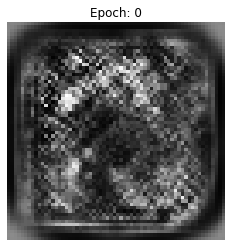

Epoch: 0, Step: 0, D-Loss: 0.104, D-Acc: 99.000, G-Loss: 2.623
Epoch: 0, Step: 50, D-Loss: 2.159, D-Acc: 50.000, G-Loss: 0.037
Epoch: 0, Step: 100, D-Loss: 2.619, D-Acc: 50.000, G-Loss: 0.006
Epoch: 0, Step: 150, D-Loss: 3.145, D-Acc: 50.000, G-Loss: 0.003
Epoch: 0, Step: 200, D-Loss: 3.317, D-Acc: 49.000, G-Loss: 0.002
Epoch: 0, Step: 250, D-Loss: 3.558, D-Acc: 49.000, G-Loss: 0.001
Epoch: 0, Step: 300, D-Loss: 3.676, D-Acc: 48.000, G-Loss: 0.001
Epoch: 0, Step: 350, D-Loss: 3.962, D-Acc: 48.000, G-Loss: 0.001
Epoch: 0, Step: 400, D-Loss: 3.962, D-Acc: 49.000, G-Loss: 0.001
Epoch: 0, Step: 450, D-Loss: 3.916, D-Acc: 51.000, G-Loss: 0.000
Epoch: 1, Step: 0, D-Loss: 4.118, D-Acc: 49.000, G-Loss: 0.000
Epoch: 1, Step: 50, D-Loss: 4.192, D-Acc: 50.000, G-Loss: 0.000
Epoch: 1, Step: 100, D-Loss: 4.277, D-Acc: 49.000, G-Loss: 0.000
Epoch: 1, Step: 150, D-Loss: 4.467, D-Acc: 49.000, G-Loss: 0.000
Epoch: 1, Step: 200, D-Loss: 4.505, D-Acc: 49.000, G-Loss: 0.000
Epoch: 1, Step: 250, D-Loss: 4.

KeyboardInterrupt: 

In [12]:
epochs = 200
batch_size = 100
steps = 500
noise_size = 100
show_sample = True

for i in range(0, epochs):
    if show_sample and i % 10 == 0:
        fake_samples = get_fake_samples(generator_network, 1, noise_size).reshape(img_size)
        plt.title(f'Epoch: {i}')
        plt.axis('off')
        plt.imshow(fake_samples, cmap='gray')
        plt.show()
    for j in range(steps):
        fake_samples = get_fake_samples(generator_network, batch_size//2, noise_size).reshape((50,img_size[0],img_size[1]))
        real_samples = get_real_samples(batch_size=batch_size//2)

        fake_y = np.zeros((batch_size//2, 1))
        real_y = np.ones((batch_size//2, 1))
        
        input_batch = np.vstack((fake_samples, real_samples))
        output_labels = np.vstack((fake_y, real_y))
        
        discriminator_network.trainable=True
        loss_d = discriminator_network.train_on_batch(input_batch, output_labels)
        
        gan_input = get_random_noise(batch_size, noise_size)
        
        gan_output = np.ones((batch_size))
        
        discriminator_network.trainable=False
        loss_g = dcgan_model.train_on_batch(gan_input, gan_output)
        
        if j % 50 == 0:
            print(f'Epoch: {i}, Step: {j}, D-Loss: {loss_d[0]:.3f}, D-Acc: {loss_d[1] * 100:.3f}, G-Loss: {loss_g:.3f}')

In [49]:
generator_network.save(os.getcwd() + '\\dc_generator')
discriminator_network.save(os.getcwd() + '\\dc_discriminator')
dcgan_model.save(os.getcwd() + '\\dc_gan_model')

INFO:tensorflow:Assets written to: c:\Users\nikhi\OneDrive\Documents\gan testing\dc_generator\assets
INFO:tensorflow:Assets written to: c:\Users\nikhi\OneDrive\Documents\gan testing\dc_discriminator\assets
INFO:tensorflow:Assets written to: c:\Users\nikhi\OneDrive\Documents\gan testing\dc_gan_model\assets


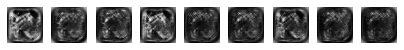

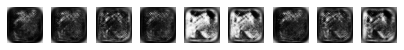

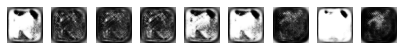

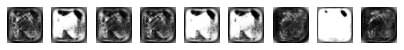

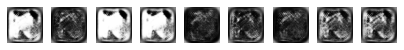

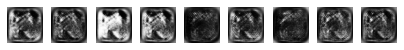

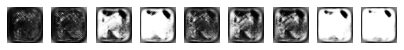

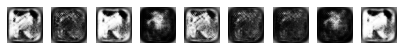

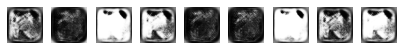

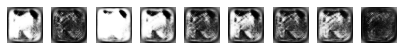

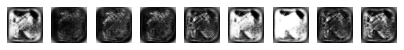

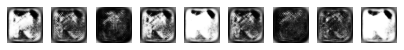

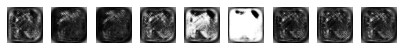

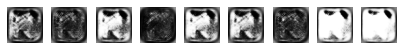

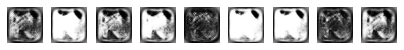

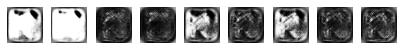

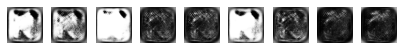

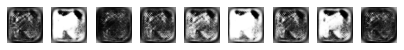

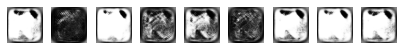

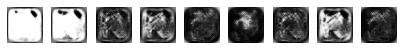

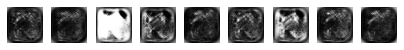

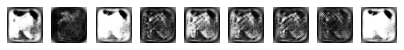

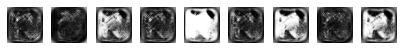

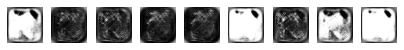

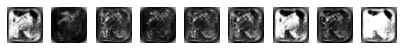

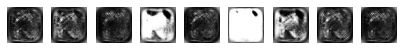

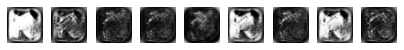

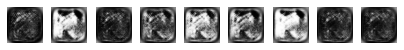

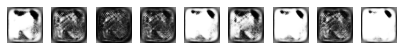

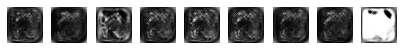

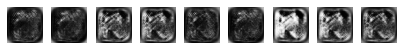

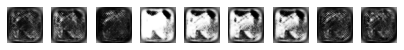

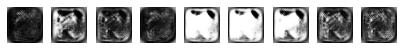

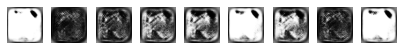

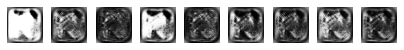

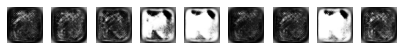

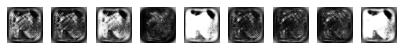

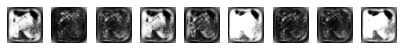

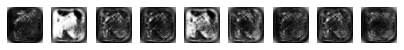

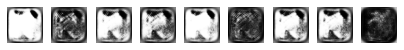

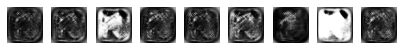

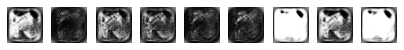

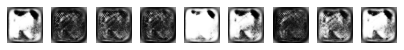

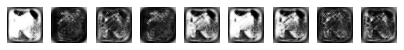

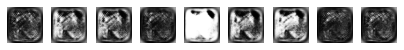

In [48]:
for i in range(5):
    show_generator_results(generator_network)

In [47]:
steps = [i for i in range(len(losses_d))]
plt.style.use('ggplot')
plt.figure(figsize=(10, 6))
plt.plot(loss_d[:5000])
plt.plot(loss_g[:5000])
plt.xlabel('Steps')
plt.ylabel('Loss Value')
plt.title("GAN: Loss Trends")
plt.legend(['Discriminator Loss', 'Generator Loss'])
plt.show()

NameError: name 'losses_d' is not defined

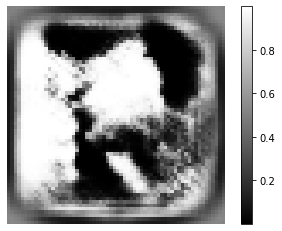

In [39]:
fake_samples = get_fake_samples(generator_network, 1, noise_size).reshape(img_size)
plt.axis('off')
plt.imshow(fake_samples, cmap='gray')
plt.colorbar()

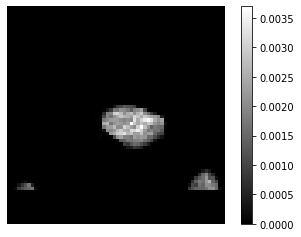

In [62]:
plt.axis('off')
plt.imshow(trainX[0] / 255, cmap='gray')
plt.colorbar()

# kms, you forgot to normalize